## Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

## Data import

In [2]:
cars_file = "https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv"
cars = pd.read_csv(cars_file)
cars.head(10)

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


#### Visualise the model

<AxesSubplot:xlabel='wt', ylabel='mpg'>

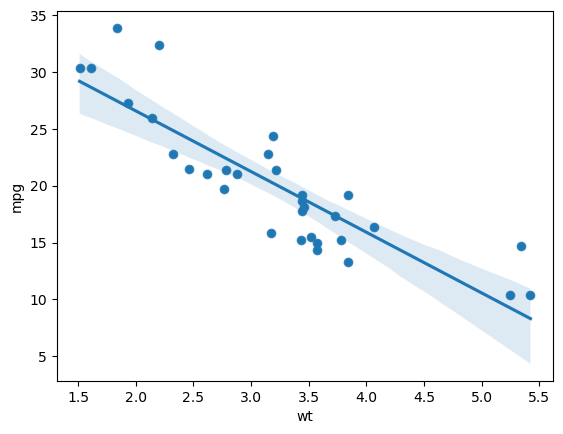

In [3]:
sns.scatterplot(x = "wt", y = "mpg", data = cars)
sns.regplot(x = "wt", y = "mpg", data = cars)

#### Convert data to tensors

In [4]:
x_list = cars.wt.values
x_np = np.array(x_list, dtype = np.float32).reshape(-1, 1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype = np.float32).reshape(-1, 1)
x = torch.from_numpy(x_np)
y_true = torch.from_numpy(y_np)

## Dataset and Dataloader

In [5]:
class LinearRegressionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
train_loader = DataLoader(dataset = LinearRegressionDataset(x_np, y_np), batch_size = 2)

## Model Class

In [6]:
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size, learning_rate):
        super(LinearRegressionTorch, self).__init__() # Inherited from parent
        self.linear = nn.Linear(input_size, output_size)
        self.loss_fun = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr = learning_rate)
        
    def forward(self, x):
        return self.linear(x) # Built-in method inherited from nn.Module

input_dim = 1
output_dim = 1
LR = 0.02
model = LinearRegressionTorch(input_size = input_dim, output_size = output_dim, learning_rate = LR)
model.train()

LinearRegressionTorch(
  (linear): Linear(in_features=1, out_features=1, bias=True)
  (loss_fun): MSELoss()
)

## Hyperparameter Tuning

In [7]:
net = NeuralNetRegressor(LinearRegressionTorch,
                        max_epochs = 10,
                        lr = 0.1,
                        # Shuffle training data on each epoch
                        iterator_train_shuffle = True,
                        )
net.set_params(train_split = False, verbose = 1)
params = {
    "lr":[0.02, 0.002, 0.001, 0.005],
    "max_epochs":[10, 100, 1000, 5000],
}

gs = GridSearchCV(net, params, refit = False, cv = 3, scoring = "r2", verbose = 2)
gs.fit(x, y_true)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END ............................lr=0.02, max_epochs=100; total time=   0.0s
[CV] END ............................lr=0.02, max_epochs=100; total time=   0.0s
[CV] END ............................lr=0.02, max_epochs=100; total time=   0.0s
[CV] END ...........................lr=0.02, max_epochs=1000; total time=   0.0s
[CV] END ...........................lr=0.02, max_epochs=1000; total time=   0.0s
[CV] END ...........................lr=0.02, max_epochs=1000; total time=   0.0s
[CV] END ...........................lr=0.02, max_epochs=5000; total time=   0.0s
[CV] END ...........................lr=0.02, max_epochs=5000; total time=   0.0s
[CV] END ...........................lr=0.02, max

/home/furkan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/home/furkan/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/furkan/anaconda3/lib/python3.9/site-packages/skorch/regressor.py", line 91, in fit
    return super(NeuralNetRegressor, self).fit(X, y, **fit_params)
  File "/home/furkan/anaconda3/lib/python3.9/site-packages/skorch/net.py", line 1228, in fit
    self.initialize()
  File "/home/f

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.LinearRegressionTorch'>,
),
             param_grid={'lr': [0.02, 0.002, 0.001, 0.005],
                         'max_epochs': [10, 100, 1000, 5000]},
             refit=False, scoring='r2', verbose=2)